# Deep Learning &mdash; Assignment 10

Assignment for week 10 of the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

------

**Names: Luka Mucko, Luca Poli**

**Group: 46**

-----


**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a variational autoencoder
2. Extend the model to a conditional VAE

## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [1]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

## 10.1 MNIST dataset (no points)

In this assignment we will use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divided over 10 classes.

**(a) Run the code below to load the MNIST dataset.**

In [2]:
opts = {'batch_size':32, 'shuffle':True}
train_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    **opts)
test_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    **opts)
num_classes = 10

## 10.2 Variational Autoencoder (VAE) (3 points)

We will implement a Variational Autoencoder. This model consists of two networks: an encoder and a decoder.
The encoder produces a distribution in the latent space, represented as the parameters of a normal distribution. The decoder takes the latent space representation and produces an output in the data space.

**(a) Complete the implementation below.<span style="float:right"> (2 points)</span>**

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_size=2):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        self.encoder_part1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)
        
        # Components of the decoder
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: Choose an appropriate activation function for the final layer.
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_part1(x)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        eps = torch.randn_like(mean_z)
        std_z = torch.exp(0.5 * logvar_z)
        # TODO: turn the sample ε from N(0,1) into a sample from N(μ,σ)
        return mean_z + eps * std_z

    def decode(self, z):
        h = self.decoder_part1_z(z)
        h = torch.reshape(h, (-1,64,7,7)) # Unflatten
        return self.decoder_part2(h)

    def forward(self, x):
        mean_z, logvar_z = self.encode(x)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z), mean_z, logvar_z

In [4]:
# Here are some unit tests for the VAE
samples = VAE().sample_latent(torch.ones(10000), torch.ones(10000))
assert F.mse_loss(torch.mean(samples), torch.tensor(1.)) < 1e-3, \
      'sample_latent should produce values with the specified mean'
assert F.mse_loss(torch.log(torch.var(samples)), torch.tensor(1.)) < 1e-3, \
      'sample_latent should produce values with the specified log variance'

The decoder produces two outputs that together give the parameters of a normal distribution: mean and logvar, so $\mu$ and $\log(\sigma^2)$. The latter might seem strange, but there is a good reason for doing it this way. 

**(b) What can go wrong if the encoder network directly outputs mean and standard deviation (μ,σ)?<span style="float:right"> (1 point)</span>**

Using log-variance instead of directly outputting the standard deviation is a common practice in VAEs for numerical stability and optimization reasons. Also, if the network directly outputs the standard deviation, it could potentially produce negative values for σ, which is not meaningful.

## 10.3 Loss function (2 points)

The loss for a variational autoencoder consists of two parts:
1. The reconstruction loss, which is the log likelihood of the data,
$L_\text{R} = \log P(x\mid z)$.
2. The Kulback-Leibler divergence from the encoder output to the target distribution,
$L_\text{KL}= KL(Q(z)\| P(z))$.

In our case the data is binary, so we can use [binary cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html) for the reconstruction loss.

The derivation of the KL loss term can be found in appendix B of the VAE paper; [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/pdf/1312.6114.pdf). Be careful:
* the paper defines $-D_{KL}$, not $D_{KL}$
* the sum is only over the latent space. In our code this corresponds to `axis=1`. Use the mean over the samples in the batch (`axis=0`).

**(a) Implement the KL loss term below.<span style="float:right"> (2 points)</span>**

In [5]:
def reconstruction_loss(recon_x, x):
    # The reconstruction loss is binary cross entropy
    # Note: we normalize the loss wrt. the batch size (len(x)), but not the size of the image
    return F.binary_cross_entropy(recon_x, x, reduction='sum') / len(x)

def kl_loss(mean_z, logvar_z):
    # The KL divergence between a standard normal distribution and
    #  a normal distribution with given mean and log-variance.
    # TODO: your code here
    return -0.5 * torch.sum(1 + logvar_z - mean_z.pow(2) - logvar_z.exp()) / len(mean_z)

def loss_function(recon_x, x, mean_z, logvar_z):
    l_recon = reconstruction_loss(recon_x, x)
    l_kl    = kl_loss(mean_z, logvar_z)
    return l_recon + l_kl, l_recon, l_kl

In [6]:
# Here are some unit tests for the loss function
assert kl_loss(torch.tensor([[0]]), torch.tensor([[0]])) == 0, \
      'KL loss should be 0 for μ=0, σ=1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[-1]])) > 0, \
      'KL loss should be > 0 for μ=0, σ<1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[1]])) > 0, \
      'KL loss should be > 0 for μ=0, σ>1'
assert kl_loss(torch.tensor([[1]]), torch.tensor([[0]])) > 0, \
      'KL loss should be > 0 for μ!=0, σ=1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[1]])) == \
       kl_loss(torch.tensor([[0,0]]), torch.tensor([[1,1]])) / 2, \
      'Take the sum over the latent dimensions'
assert kl_loss(torch.tensor([[0,0,1]]), torch.tensor([[0,1,-0.5]])) == \
       kl_loss(torch.tensor([[0,0,1],[0,0,1]]), torch.tensor([[0,1,-0.5],[0,1,-0.5]])), \
      'Take the mean over the items in the batch or normalize wrt. batch size (see also reconstruction_loss)'

## 10.4 Training our VAE (3 points)

**(a) Complete the training loop below<span style="float:right"> (2 points)</span>**

In [44]:
def train(model, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'train recon. loss', 'train KL loss',
                                    'test loss', 'test recon. loss', 'test KL loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for x, y in train_iter:
            x = x.to(device)
            optimizer.zero_grad()
            # TODO: compute the outputs and loss
            recon_x, mean_x, var_x = model(x)
            loss, loss_recon, loss_kl = loss_function(recon_x, x, mean_x, var_x)
            # TODO: backpropagate and apply optimizer
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_recon.detach(), loss_kl.detach(), x.shape[0])
        # Compute test loss
        test_loss, test_loss_recon, test_loss_kl = test(model)
        # Plot
        train_loss_recon = metric[0] / metric[2]
        train_loss_kl    = metric[1] / metric[2]
        train_loss = train_loss_recon + train_loss_kl
        animator.add(epoch + 1,
                     (train_loss, train_loss_recon, train_loss_kl,
                      test_loss, test_loss_recon, test_loss_kl))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_recon:.3f}, test reconstruction loss {test_loss_recon:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iter):
            x = x.to(device)
            # TODO: compute the outputs and loss
            recon_x, mean_x, var_x = model(x)
            loss, loss_recon, loss_kl = loss_function(recon_x, x, mean_x, var_x)
            metric.add(loss_recon, loss_kl, x.shape[0])
    test_loss_recon = metric[0] / metric[2]
    test_loss_kl    = metric[1] / metric[2]
    return test_loss_recon + test_loss_kl, test_loss_recon, test_loss_kl

**(b) Train the model.<span style="float:right"> (no points)</span>**

Hint: the training and test loss should both be around 5.

training loss 4.741, test loss 4.754
training reconstruction loss 4.543, test reconstruction loss 4.553
training KL loss 0.198, test KL loss 0.202


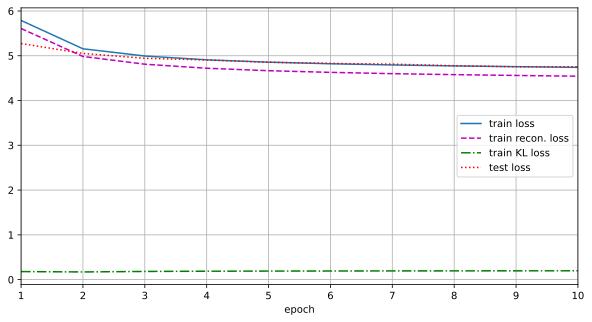

In [53]:
device = d2l.try_gpu()
model = VAE(latent_size=2).to(device)
train(model)

**(c) If you increase the number of latent dimensions, how does that affect the reconstruction loss and the KL loss terms?<span style="float:right"> (1 point)</span>**

The reconstruction loss should decrease because, with more dimensions, is easier to capture intricate details and relation in the data; so it's also easier to reconstruct the input form a higher dimensional space.

The KL divergence loss should increase because, with more dimensions, the model has more flexibility to deviate from a standard distribution.

## 10.5 Visualizing the latent space (8 points)

We can use the function below to visualize the 2D latent space, by running the decoder on $z$ values sampled at regular intervals.

**(a) Complete the code below and run it to plot the latent space.<span style="float:right"> (1 point)</span>**

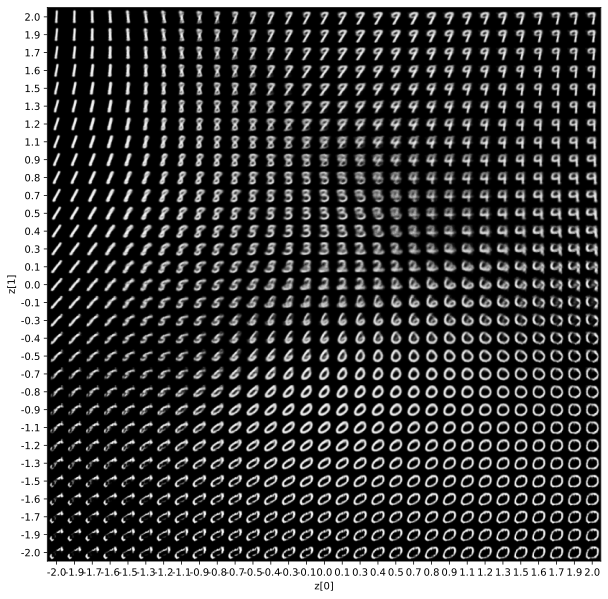

In [54]:
def plot_latent(model):
    # display a n*n 2D manifold of digits
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.Tensor([xi, yi])
            x_decoded = model.decode(z)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(model)

**(b) Would it be possible to classify digits based on this latent representation? Explain your answer.<span style="float:right"> (1 point)</span>**

We can use this latent space only if it has meaningful structure (if the VAE is well-trained, similar digits might be close to each other in the latent space). In such cases, we could train a classifier on top of the latent space to perform digit classification.

**(c) If you retrain the model, would you expect the latent space to look exactly the same. If not, what differences can you expect?<span style="float:right"> (1 point)</span>**

After the retraining we can expect the latent space to change, because it does depend on the model and its training. But we expect the latent space to have a similar structure (with adjacent symbols being similar), so the exact arrangement of the points can change, but the overall structure and relation between points is the same.

Another way of visualizing the latent space is by making a scatter plot of the training data in the latent space.

**(d) Complete and run the code below to make a scatterplot of the training data.<span style="float:right"> (1 point)</span>**

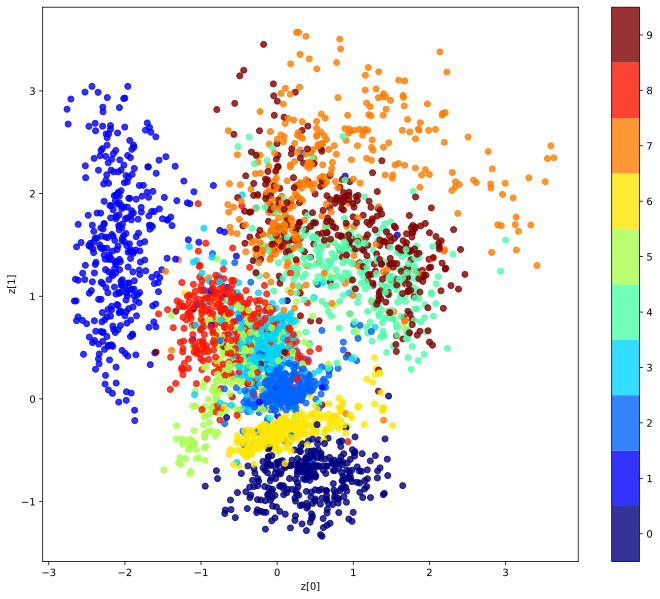

In [55]:
def scatterplot_latent(model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for x, y in itertools.islice(train_iter, 100):
        # TODO: compute mean z
        z_mean, _= model.encode(x)
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()
    
    cmap = plt.get_cmap('jet', 10)
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys, cmap=cmap, alpha=0.8, vmin=-0.5, vmax=9.5)
    plt.colorbar(ticks=np.arange(0, 10))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

scatterplot_latent(model)

**(e) Compare this figure to the one from `plot_latent`. How are the plots related?<span style="float:right"> (1 point)</span>**

Note: Don't just answer "both visualize the latent space"

We can see from these plots that similar number are place near each other in both of the plots. For example 3 and 5 (but also 0 and 6) are similar, and in both of the plot they are placed near each other.

**(f) Compared to the figure from `plot_latent`, what information about the VAE is shown in this figure but not in the previous one?<span style="float:right"> (1 point)</span>**

In this plot we can see new information such as the density of the data points, global structure and the distribution of the training data point in the latent space.

**(g) What distribution should we expect the points in the latent space to follow, based on the KL divergence term in the loss function?<span style="float:right"> (1 point)</span>**

We expect the latent space to follow a Normal distribution, this due to the KL divergence term in the loss function that encourages the latent space to follow this distribution.

**(h) Look at the distribution of the data in the latent space. Does the plot match the answer to the previous question? If not, why?<span style="float:right"> (1 point)</span>**

It doesn't match exactly a normal distribution, but it looks similar. Because, the final distribution, depend on: the model, the data complexity, the training and on expressiveness of Latent Space.

## 10.6 Conditional Variational Autoencoder (10 points)

An extension of variational autoencoders uses labels to *condition* the encoder and decoder models.
In this *conditional VAE*, the decoder becomes $P(x|z,y)$ and the encoder $Q(z|x,y)$.
In practice, this means that the label $y$ is given as an extra input to the both the encoder and the decoder.

For details see the paper [Semi-Supervised Learning with Deep Generative Models; Kingma, Rezende, Mohamed, Welling; 2014](https://arxiv.org/pdf/1406.5298.pdf).

To use the labels in the decoder, we can concatenate the label with the latent vector. Or equivalently, we can use separate weights for $z$ and $y$ in the first layer, so that layer computes $W_z \cdot z + W_y \cdot y + b$.

Similarly for the encoder, except there we will still use a convolutional layer for $x$, combined with a fully connected layer for $y$.

**(a) Complete the implementation of the conditional VAE below.<span style="float:right"> (3 points)</span>**

In [13]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_size=2, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        # TODO: split the first layer from the previous encoder network into a separate variable,
        #       and add a layer to use with the y input
        self.encoder_part1_x = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2)
        self.encoder_part1_y = nn.Linear(num_classes, 32*14*14)
        
        self.encoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder network
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        # TODO: add layer to use with the y input
        self.decoder_part1_y = nn.Linear(num_classes, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: see VAE
            nn.Sigmoid()
        )

    def encode(self, x, y):
        h = self.encoder_part1_x(x) + self.encoder_part1_y(y).reshape(-1,32,14,14)
        h = self.encoder_part2(h)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        eps = torch.randn_like(mean_z)
        std_z = torch.exp(0.5 * logvar_z)
        return mean_z + eps * std_z

    def decode(self, z, y):
        # TODO: use a first layer that combines z and y
        h = self.decoder_part1_z(z) + self.decoder_part1_y(y)
        h = torch.reshape(h, (-1,64,7,7))
        return self.decoder_part2(h)

    def forward(self, x, y):
        mean_z, logvar_z = self.encode(x, y)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z, y), mean_z, logvar_z

**(b) Copy the training code from section 10.4, and modify it for a conditional VAE.<span style="float:right"> (1 point)</span>**

Hint: To train the conditional VAE we need to use one-hot encoding of the labels. You can use the following code for that:

    y = F.one_hot(y,10).float().to(device)

In [16]:
def train_cvae(model, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'train recon. loss', 'train KL loss',
                                    'test loss', 'test recon. loss', 'test KL loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for x, y in train_iter:
            x = x.to(device)
            y = F.one_hot(y,10).float().to(device)
            optimizer.zero_grad()
            # TODO: compute the outputs and loss
            recon_x, mean_x, var_x = model(x, y)
            loss, loss_recon, loss_kl = loss_function(recon_x, x, mean_x, var_x)
            # TODO: backpropagate and apply optimizer
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_recon.detach(), loss_kl.detach(), x.shape[0])
        # Compute test loss
        test_loss, test_loss_recon, test_loss_kl = test_cvae(model)
        # Plot
        train_loss_recon = metric[0] / metric[2]
        train_loss_kl    = metric[1] / metric[2]
        train_loss = train_loss_recon + train_loss_kl
        animator.add(epoch + 1,
                     (train_loss, train_loss_recon, train_loss_kl,
                      test_loss, test_loss_recon, test_loss_kl))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_recon:.3f}, test reconstruction loss {test_loss_recon:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')

def test_cvae(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iter):
            x = x.to(device)
            y = F.one_hot(y,10).float().to(device)
            # TODO: compute the outputs and loss
            recon_x, mean_x, var_x = model(x, y)
            loss, loss_recon, loss_kl = loss_function(recon_x, x, mean_x, var_x)
            metric.add(loss_recon, loss_kl, x.shape[0])
    test_loss_recon = metric[0] / metric[2]
    test_loss_kl    = metric[1] / metric[2]
    return test_loss_recon + test_loss_kl, test_loss_recon, test_loss_kl

In [33]:
index = torch.tensor([4])

# Specify the number of classes (10 in this case)
num_classes = 10

# Use F.one_hot to create a one-hot encoded vector
one_hot_encoded = F.one_hot(index, num_classes)

print(one_hot_encoded)

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


**(c) Train a conditional VAE**

training loss 4.102, test loss 4.119
training reconstruction loss 3.955, test reconstruction loss 3.978
training KL loss 0.147, test KL loss 0.141


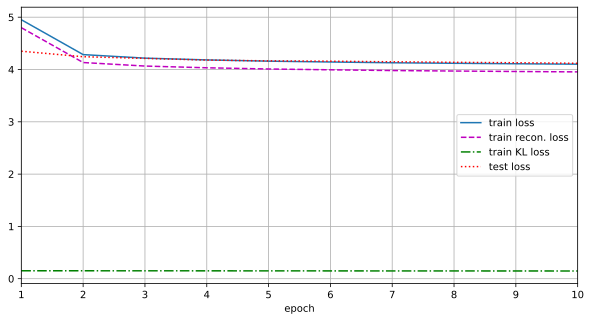

In [17]:
cvae_model = ConditionalVAE().to(device)
train_cvae(cvae_model)

**(d) Adapt the `plot_latent` function from section 10.5 for conditional VAEs, and use your function to visualize the latent space for the classes `4` and `8`.<span style="float:right"> (1 point)</span>**

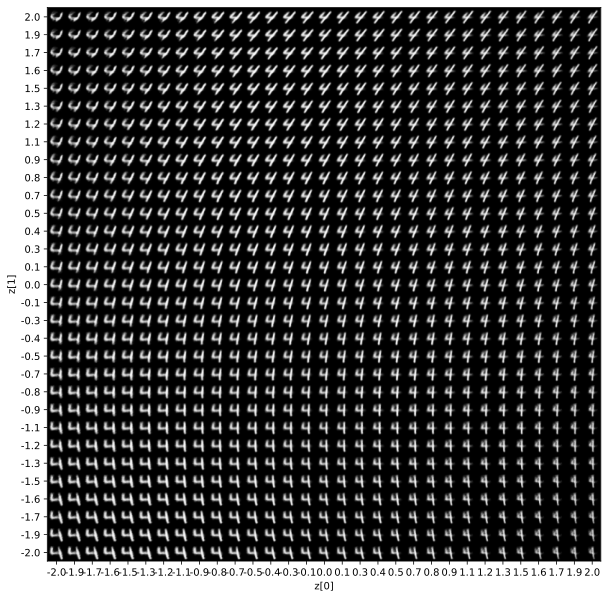

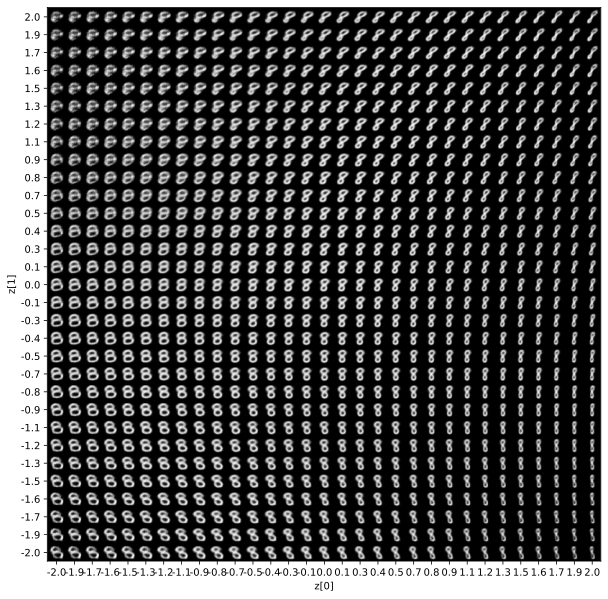

In [43]:
def plot_latent_cvae(model, y, device=d2l.try_gpu()):    # TODO: your code here
    # display a n*n 2D manifold of digits
    device= d2l.try_gpu()
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    y = F.one_hot(torch.tensor([y]), 10).float().to(device)
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.Tensor([xi, yi]).to(device)
            x_decoded = model.decode(z, y)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_cvae(cvae_model, 4)
plot_latent_cvae(cvae_model, 8)

**(e) What do the latent dimensions represent? Is this the same for all labels?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(f) Adapt `scatterplot_latent` to show the distribution in the latent space.<span style="float:right"> (1 point)</span>**

In [ ]:
def scatterplot_latent_cvae(cvae_model):
    # display a 2D plot of the digit classes in the latent space
    

scatterplot_latent_cvae(cvae_model)

**(g) How is this distribution in the latent space different from the distribution of the VAE? Compare to your answer to that for question 10.5 g and h. What is the cause of these differences?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(h) Would it be possible to classify digits based on the latent representation of the conditional VAE? Explain your answer.<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(i) Describe how you could use a conditional VAE to change the label or content of an image, while keeping the style as similar as possible.<span style="float:right"> (1 point)</span>**

TODO: your answer here

## 10.7 Discussion (2 points)

**(a) Is the conditional VAE a strict improvement over the normal VAE in all cases?<span style="float:right"> (1 point)</span>**

TODO: your answer here

**(b) Compare the latent representation vector $z$ in the VAE with the input for the generator in a GAN. They are both small vectors, and they are both often called $z$. In what way are they the same, and in what way are the different?<span class="float:right"> (1 point)</span>**

TODO: your answer here

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 28 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 7536f1e / 2023-11-15</span>